Standard UCB
Wi/ni + C * sqrt(ln(N)/ni) C = constant (2)

Updated UBC


w/n + Pi*C * sqrt(Ni)/1+n
G -> [G,T,A,C,H,a,b,1,2,-1,-2,E]
All nodes should store the following information:
1. The value of the node
2. The number of games played
3. The probability of nodes coming from the NN

Training data stores the information as (states, MCTS probabilities, reward (who won))
s, pi, z = Sample
f(s) = (p,v) output from NN
loss = (z-v)^2 - pi^T * log(p) + c||theta||^2 (pi is the distribution from MCTS where p is the distribution from NN)


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
from tqdm.notebook import trange
import random

In [8]:
class TicTacToe:
    def __init__(self) -> None:
        self.row_count = 3
        self.column_count = 3
        self.action_size = self.row_count * self.column_count

    def __repr__(self):
        return "TicTacToe"
    
    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = player
        return state
    
    def get_valid_moves(self, state):
        return (state.reshape(-1) == 0).astype(np.uint8)
    
    def check_win(self,state,action):
        if action == None:
            return False
        row = action // self.column_count
        column = action % self.column_count
        player = state[row, column]

        return (
            np.sum(state[row, :]) == player * self.column_count or
            np.sum(state[:, column]) == player * self.row_count or
            np.sum(np.diag(state)) == player * self.row_count or
            np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count
        )

    def get_value_and_terminated(self,state,action):
        if self.check_win(state,action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False
    
    def get_opponent(self,player):
        return -player
    
    def get_opponent_value(self,value):
        return -value
    
    def change_perspective(self,state,player):
        return state * player
    
    def get_encoded_state(self,state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1),
        ).astype(np.float32)
        
        if len(state.shape)==3:
            encoded_state = np.swapaxes(encoded_state,0,1)
        return encoded_state

In [9]:
class ConnectFour:
    def __init__(self) -> None:
        self.row_count = 6
        self.column_count = 7
        self.action_size = self.column_count
        self.in_a_row = 4

    def __repr__(self):
        return "ConnectFour"
    
    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = np.max(np.where(state[:, action] == 0))
        state[row, action] = player
        return state
    
    def get_valid_moves(self, state):
        return (state[0] == 0).astype(np.uint8)
    
    def check_win(self,state,action):
        if action == None:
            return False
        row = np.min(np.where(state[:, action] !=0))
        column = action
        player = state[row][column]

        def count(offset_row, offset_column):
            for i in range(1, self.in_a_row):
                r = row + offset_row * i
                c = column + offset_column * i
                if (
                    r<0
                    or r>=self.row_count
                    or c<0
                    or c>=self.column_count
                    or state[r][c] != player
                ):
                    return i-1
            return self.in_a_row-1
        return(
            count(1,0) >= self.in_a_row-1 # vertical
            or (count(0,1) + count(0,-1)) >= self.in_a_row-1 # horizontal
            or (count(1,1) + count(-1,-1)) >= self.in_a_row-1 # left diagonal
            or (count(1,-1) + count(-1,1)) >= self.in_a_row-1 # right diagonal
        )


    def get_value_and_terminated(self,state,action):
        if self.check_win(state,action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False
    
    def get_opponent(self,player):
        return -player
    
    def get_opponent_value(self,value):
        return -value
    
    def change_perspective(self,state,player):
        return state * player
    
    def get_encoded_state(self,state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1),
        ).astype(np.float32)

        if len(state.shape)==3:
            encoded_state = np.swapaxes(encoded_state,0,1)
        return encoded_state

In [10]:
class ResNet(nn.Module):
    def __init__(self,game,num_resBlocks,num_hidden):
        super().__init__()
        self.startBlock = nn.Sequential(
            nn.Conv2d(3,num_hidden,kernel_size=3,padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for _ in range(num_resBlocks)]
        )
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden,32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*game.row_count*game.column_count,game.action_size),
        )
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden,3,kernel_size=3,padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3*game.row_count*game.column_count,1),
            nn.Tanh()
        )

    def forward(self,x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value
    
class ResBlock(nn.Module):
    def __init__(self,num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden,num_hidden,kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden,num_hidden,kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self,x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

[[ 0.  0. -1.]
 [ 0. -1.  0.]
 [ 1.  0.  1.]]
[[[0. 0. 1.]
  [0. 1. 0.]
  [0. 0. 0.]]

 [[1. 1. 0.]
  [1. 0. 1.]
  [0. 1. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [1. 0. 1.]]]
0.900261402130127


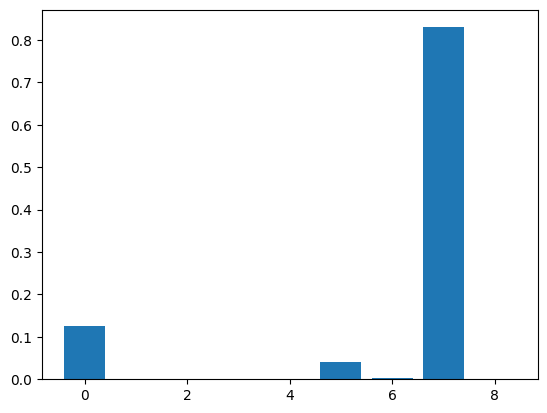

In [11]:
import matplotlib.pyplot as plt
ttt = TicTacToe()
state = ttt.get_initial_state()
state = ttt.get_next_state(state,2,-1)
state = ttt.get_next_state(state,4,-1)
state = ttt.get_next_state(state,6,1)
state = ttt.get_next_state(state,8,1)
print(state)

encoded_state = ttt.get_encoded_state(state)
print(encoded_state)
tensor_state = torch.tensor(encoded_state).unsqueeze(0)
#untrained model
model = ResNet(ttt,4,64)
#trained model
model.load_state_dict(torch.load('model_2.pt'))
model.eval()
policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy,axis=1).squeeze(0).detach().numpy()
print(value)
plt.bar(range(ttt.action_size),policy)
plt.show()

In [12]:
class Node:
    def __init__(self,game,args,state,parent=None,action_taken=None,prior = 0,visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = []

        self.visit_count = visit_count
        self.value_sum = 0
    
    def is_fully_expanded(self):
        return len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_ucb = ucb
                best_child = child
        return best_child
    
    def get_ucb(self,child):
        if child.visit_count == 0:
            q_value = 0
        else:
            # 1 - because of switching player the child position is the opponent position
            q_value = 1-((child.value_sum / child.visit_count)+1)/2
        return q_value + self.args["C"] * (np.sqrt(self.visit_count) / (child.visit_count+1))*child.prior
    def expand(self,policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state,action,1)
                child_state = self.game.change_perspective(child_state,player = -1)

                child = Node(self.game,self.args,child_state,self,action,prob)
                self.children.append(child)

    def backpropagate(self,value):
        self.value_sum += value
        self.visit_count += 1
        value = self.game.get_opponent_value(value)
        if self.parent != None:
            self.parent.backpropagate(value)

class MCTS:
    def __init__(self,game,args,model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad()
    def search(self,state):
        root = Node(self.game,self.args,state,visit_count=1)
        #noise addition
        policy,_ = self.model(
            torch.tensor(self.game.get_encoded_state(state)).unsqueeze(0)
        )
        policy = torch.softmax(policy,axis=1).squeeze(0).numpy()
        
        policy = (1-self.args["dirichlet_epsilon"])*policy + self.args["dirichlet_epsilon"]\
            *np.random.dirichlet([self.args["dirichlet_alpha"]]*self.game.action_size)
        
        valid_moves = self.game.get_valid_moves(state)
        policy*=valid_moves
        policy /= np.sum(policy)
        root.expand(policy)
        for search in range(self.args["num_searches"]):
            #selection
            node = root

            while node.is_fully_expanded():
                node = node.select()
                #some noise to promote exploration

            value,is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)

            if not is_terminal:
                policy,value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state)).unsqueeze(0)
                )
                policy = torch.softmax(policy,axis=1).squeeze(0).numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy = policy * valid_moves
                policy /= np.sum(policy)

                value = value.item()

                #expansion
                node.expand(policy)
            #backpropagation
            node.backpropagate(value)
        
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs
        #return visit_counts

In [13]:
class Alphazero:
    def __init__(self,model,optimizer,game,args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game,args,model)

    def selfPlay(self):
        memory = []
        player = 1 
        state = self.game.get_initial_state()

        while True:
            neutral_state = self.game.change_perspective(state,player)
            action_probs = self.mcts.search(neutral_state)
            memory.append((neutral_state,action_probs,player))
            #Temperature lim 0 exploiation, lim inf exploration (more randomness)
            temperature_action_probs = action_probs**(1/self.args["temperature"])
            temperature_action_probs /= np.sum(temperature_action_probs)

            action = np.random.choice(self.game.action_size,p=temperature_action_probs)
            state = self.game.get_next_state(state,action,player)
            value,is_terminal = self.game.get_value_and_terminated(state,action)
            if is_terminal:
                returnMemory = []
                for hist_neutral_state,hist_action_probs,hist_player in memory:
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    returnMemory.append((
                        self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                return returnMemory
            player = self.game.get_opponent(player)


    def train(self,memory):
        random.shuffle(memory)
        for batchIdx in range(0,len(memory),self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory)-1,batchIdx+self.args['batch_size'])]
            state,policy_targets,value_targets = zip(*sample)
            state,policy_targets,value_targets = np.array(state),np.array(policy_targets),np.array(value_targets).reshape(-1,1)
            state = torch.tensor(state).float()
            policy_targets = torch.tensor(policy_targets).float()
            value_targets = torch.tensor(value_targets).float()
            
            out_policy, out_value = self.model(state)

            policy_loss = F.cross_entropy(out_policy,policy_targets)
            value_loss = F.mse_loss(out_value,value_targets)
            loss = policy_loss + value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            

    def learn(self):
        for iteration in range(self.args["num_iterations"]):
            memory = []

            for selfPlay_iteration in trange(self.args["num_selfPlay_iterations"]):
                memory += self.selfPlay()
            self.model.train()
            for epoch in trange(self.args["num_epochs"]):
                self.train(memory)
            
            torch.save(self.model.state_dict(),f"model_{iteration}_{self.game}.pt")
            torch.save(self.optimizer.state_dict(),f"optimizer_{iteration}_{self.game}.pt")

In [19]:
class AlphazeroParallel:
    def __init__(self,model,optimizer,game,args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS_Parallel(game,args,model)

    def selfPlay(self):
        retun_memory = []
        player = 1
        sgGames = [SPG(self.game) for spg in range(self.args["num_parallel_games"])]

        while len(sgGames) > 0:
            states = np.stack([spg.state for spg in sgGames])

            neutral_states = self.game.change_perspective(states,player)
            self.mcts.search(neutral_states,sgGames)

            for i in range(len(sgGames))[::-1]:
                spg = sgGames[i]
                action_probs = np.zeros(self.game.action_size)
                for child in spg.root.children:
                    action_probs[child.action_taken] = child.visit_count
                action_probs /= np.sum(action_probs)
                #return visit_counts
                spg.memory.append((spg.root.state,action_probs,player))
                #Temperature lim 0 exploiation, lim inf exploration (more randomness)
                temperature_action_probs = action_probs**(1/self.args["temperature"])
                temperature_action_probs /= np.sum(temperature_action_probs)

                action = np.random.choice(self.game.action_size,p=temperature_action_probs)
                spg.state = self.game.get_next_state(spg.state,action,player)
                value,is_terminal = self.game.get_value_and_terminated(spg.state,action)
                if is_terminal:
                    for hist_neutral_state,hist_action_probs,hist_player in spg.memory:
                        hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                        retun_memory.append((
                            self.game.get_encoded_state(hist_neutral_state),
                            hist_action_probs,
                            hist_outcome
                        ))
                    del sgGames[i]
            player = self.game.get_opponent(player)

        return retun_memory


    def train(self,memory):
        random.shuffle(memory)
        for batchIdx in range(0,len(memory),self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory)-1,batchIdx+self.args['batch_size'])]
            state,policy_targets,value_targets = zip(*sample)
            state,policy_targets,value_targets = np.array(state),np.array(policy_targets),np.array(value_targets).reshape(-1,1)
            state = torch.tensor(state).float()
            policy_targets = torch.tensor(policy_targets).float()
            value_targets = torch.tensor(value_targets).float()
            
            out_policy, out_value = self.model(state)

            policy_loss = F.cross_entropy(out_policy,policy_targets)
            value_loss = F.mse_loss(out_value,value_targets)
            loss = policy_loss + value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            

    def learn(self):
        for iteration in range(self.args["num_iterations"]):
            memory = []

            for selfPlay_iteration in trange(self.args["num_selfPlay_iterations"]//self.args["num_parallel_games"]):
                memory += self.selfPlay()
            self.model.train()
            for epoch in trange(self.args["num_epochs"]):
                self.train(memory)
            
            torch.save(self.model.state_dict(),f"model_{iteration}_{self.game}.pt")
            torch.save(self.optimizer.state_dict(),f"optimizer_{iteration}_{self.game}.pt")

class SPG:
    def __init__(self,game):
        self.state =game.get_initial_state()
        self.memory = []
        self.root = None
        self.node = None


In [20]:
class MCTS_Parallel:
    def __init__(self,game,args,model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad()
    def search(self,states,spGames):
        #noise addition
        policy,_ = self.model(
            torch.tensor(self.game.get_encoded_state(states))
        )
        policy = torch.softmax(policy,axis=1).numpy()
        
        policy = (1-self.args["dirichlet_epsilon"])*policy + self.args["dirichlet_epsilon"]\
            *np.random.dirichlet([self.args["dirichlet_alpha"]]*self.game.action_size,size=policy.shape[0])
        
        for i,spg in enumerate(spGames):
            spg_policy = policy[i]
            valid_moves = self.game.get_valid_moves(states[i])
            spg_policy*=valid_moves
            spg_policy /= np.sum(spg_policy)
            spg.root = Node(self.game,self.args,states[i],visit_count=1)
            spg.root.expand(spg_policy)

        for search in range(self.args["num_searches"]):
            for spg in spGames:
                #selection
                spg.node = None
                node = spg.root

                while node.is_fully_expanded():
                    node = node.select()
                    #some noise to promote exploration

                value,is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
                value = self.game.get_opponent_value(value)
                if is_terminal:
                    node.backpropagate(value)
                else:
                    spg.node = node
                
                expandable_spGames = [mappingIdx for mappingIdx in range(len(spGames)) if spGames[mappingIdx].node != None]
                if len(expandable_spGames) > 0:
                  states = np.stack([spGames[mappingIdx].node.state for mappingIdx in expandable_spGames])
                  policy,value = self.model(
                        torch.tensor(self.game.get_encoded_state(states))
                    )
                  policy = torch.softmax(policy,axis=1).numpy()

                for i,mappingIdx in enumerate(expandable_spGames):
                    node = spGames[mappingIdx].node
                    spg_policy,spg_value = policy[i],value[i]
                    valid_moves = self.game.get_valid_moves(node.state)
                    spg_policy*= valid_moves
                    spg_policy /= np.sum(spg_policy)
                    #expansion
                    node.expand(spg_policy)
                    node.backpropagate(spg_value)

In [ ]:
game = ConnectFour()
model = ResNet(game,9,128)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)
# args = {
#     "C":2,
#     "num_searches":60,
#     "num_iterations":3,
#     "num_selfPlay_iterations":500,
#     "num_epochs":4,
#     "batch_size":64,
#     "temperature":1.25,
#     "dirichlet_epsilon":0.25,
#     "dirichlet_alpha":0.3
# }
args = {
    "C":2,
    "num_searches":600,
    "num_iterations":8,
    "num_selfPlay_iterations":500,
    "num_parallel_games":100,
    "num_epochs":4,
    "batch_size":128,
    "temperature":1.25,
    "dirichlet_epsilon":0.25,
    "dirichlet_alpha":0.3
}
alphazero = AlphazeroParallel(model,optimizer,game,args)
alphazero.learn()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
game = ConnectFour()
player = 1
args = {
    "C": 2,
    "num_searches": 600,
    "dirichlet_epsilon":0.0,
    "dirichlet_alpha":0.3
}
model = ResNet(game,9,128)
model.state_dict(torch.load('model_7_ConnectFour.pt'))
model.eval()
mcts = MCTS(game, args,model)
state = game.get_initial_state()

while True:
    print(state)
    if player == 1:
        valid_moves = game.get_valid_moves(state)
        print("valid_moves", [i for i in range(game.action_size) if valid_moves[i]==1])
        action = int(input("Enter action: "))
        if valid_moves[action] == 0:
            print("action not valid")
            continue
    else:
        neutral_state = game.change_perspective(state,player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)
        
    state = game.get_next_state(state, action, player)
    value,is_terminal = game.get_value_and_terminated(state,action)

    if is_terminal:
        print(state)
        if value == 1:
            print("Player", player, "wins")
        else:
            print("Draw")
        break

    player = game.get_opponent(player)
    

In [22]:
import kaggle_environments

env = kaggle_environments.make("connectx")
players = []
env.run(players)
env.render(mode="ipython")

ModuleNotFoundError: No module named 'kaggle_environments'